# CPU Info

In [1]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          32
On-line CPU(s) list:             0-31
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2200.154
BogoMIPS:                        4400.30
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       512 KiB
L1i cache:                       512 KiB
L2 cache:                        4 MiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0-31
Vulnerabil

# Imports

In [2]:
from main import build_model, normalize_img
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

# Utility Functions

In [4]:
def build_pipelines(num_train_examples, num_test_examples):
    """
    Builds the training and test set
    """
    (ds_train, ds_test), ds_info = tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

    ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).take(
        num_train_examples
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(num_train_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).take(
        num_test_examples
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_test


In [5]:
def run_experiment(i, num_train_examples=60000, num_test_examples=10000):
    """
    Trains an model on the MNIST dataset given the number of training and test examples
    """
    ds_train, ds_test = build_pipelines(num_train_examples, num_test_examples)
    model = build_model()
    model.fit(ds_train, epochs=6, validation_data=ds_test, verbose=0)
    _, test_accuracy = model.evaluate(ds_test, verbose=0)
    return test_accuracy


# Experiments

## Variable Training Set, Fixed Test Set

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2021-11-20 22:58:31.560863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-20 22:58:32.215012: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 22:58:34.094835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached conten

CPU times: user 1h 18min 22s, sys: 50min 45s, total: 2h 9min 7s
Wall time: 32min 58s


[Text(0.5, 0, 'Training Set Size'), Text(0, 0.5, 'Test Accuracy')]

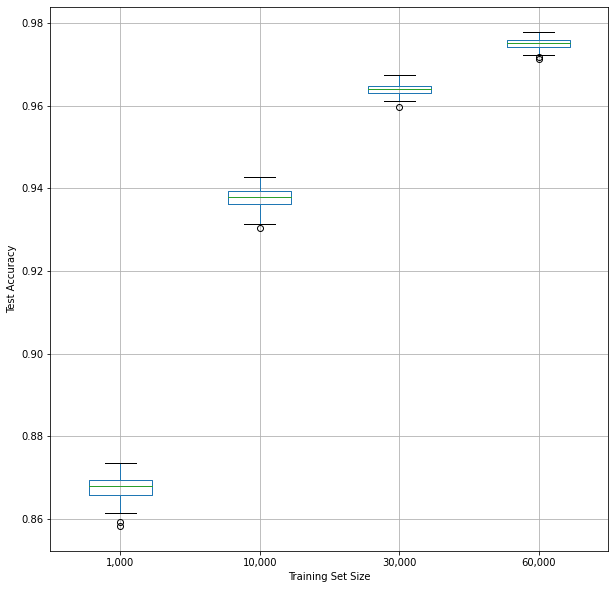

In [6]:
%%time
trials = 100

training_size = [1000, 10000, 30000, 60000]
test_size = 10000

data = [[run_experiment(i, ts, test_size) for i in range(trials)] for ts in training_size]

col_names = [str(f"{i:,}") for i in training_size]
df = pd.DataFrame(data).transpose()
df.columns = col_names

df.boxplot(col_names, figsize=(10,10))\
    .set(xlabel="Training Set Size", ylabel="Test Accuracy")

## Fixed Training Set, Variable Test Set

2021-11-20 23:31:30.514422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:31:31.129134: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:31:34.982624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

CPU times: user 1h 13s, sys: 39min 35s, total: 1h 39min 48s
Wall time: 24min 47s


[Text(0.5, 0, 'Test Set Size'), Text(0, 0.5, 'Test Accuracy')]

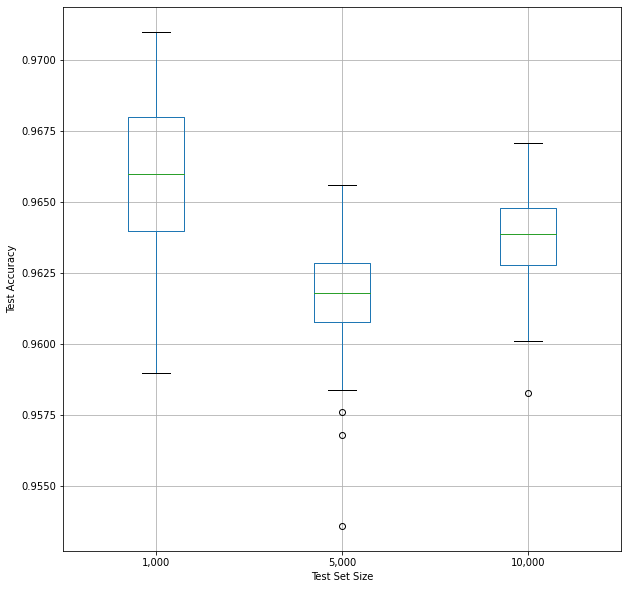

In [7]:
%%time
trials = 100

training_size = 30000
test_size = [1000, 5000, 10000]

data = [[run_experiment(i, training_size, ts) for i in range(trials)] for ts in test_size]

col_names = [str(f"{i:,}") for i in test_size]
df = pd.DataFrame(data).transpose()
df.columns = col_names

df.boxplot(col_names, figsize=(10,10))\
    .set(xlabel="Test Set Size", ylabel="Test Accuracy")

## Common Scenario

Assume 1,000 training examples and only 500 test set:

In [8]:
%%time
trials = 100

training_size = 1000
test_size = 500

data = [run_experiment(i, training_size, test_size) for i in range(trials)]

df = pd.DataFrame({f"{test_size:,}": data})

2021-11-20 23:56:18.018205: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:56:18.180248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:56:18.949463: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

CPU times: user 2min 9s, sys: 48.3 s, total: 2min 57s
Wall time: 1min 37s


Compare that with if we have access to the full test set:

2021-11-20 23:57:55.278427: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:57:57.006873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-20 23:57:58.917361: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

CPU times: user 5min 51s, sys: 3min 21s, total: 9min 12s
Wall time: 3min 15s


[Text(0.5, 0, 'Test Set Size'), Text(0, 0.5, 'Test Accuracy')]

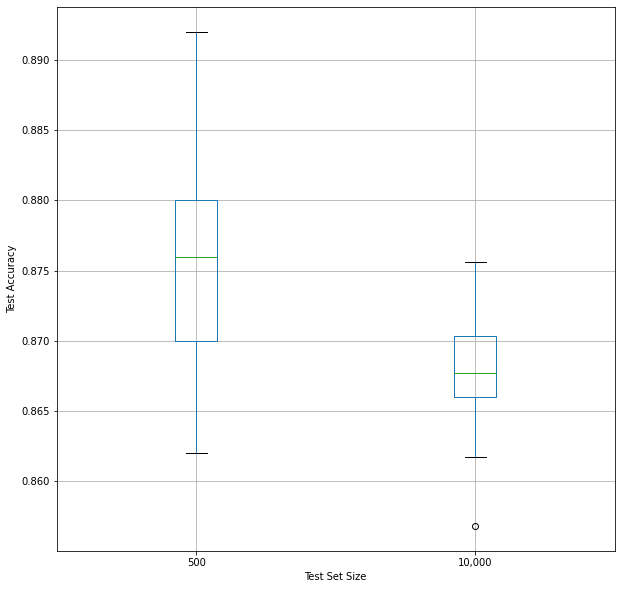

In [9]:
%%time
trials = 100

training_size = 1000
test_size = 10000

data = [run_experiment(i, training_size, test_size) for i in range(trials)]

df_full = pd.DataFrame({f"{test_size:,}": data})

df_comb = pd.concat([df, df_full], ignore_index=True, join="outer", axis=1)
df_comb.columns = ["500", "10,000"]

# visualize the results side-by-side
df_comb.boxplot(figsize=(10,10))\
    .set(xlabel="Test Set Size", ylabel="Test Accuracy")